## 메모

`-` 참고

* https://huggingface.co/docs/trl/sft_trainer
* https://github.com/hiyouga/LLaMA-Factory#hardware-requirement
* 메모리 이슈가 있다면 Unsloth를 추가적으로 고려할 수 있음...

`-` 65B 모델 파인튜닝 요구 VRAM

* Full fine-tuning(32bit): 1200GB
* QLoRA(8bit): 80GB
* QLoRA(4bit): 48GB $\leftarrow$ 가장 현실적

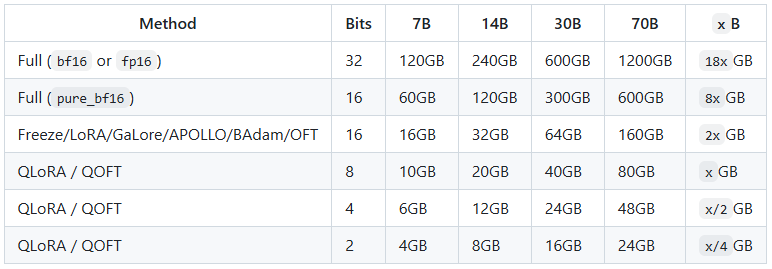

`-` 튜닝 방법

* bitsandbytes quantization: 실수형(BF16) 가중치를 4비트로 양자화
> bfloat16 $\to$ int4로 양자화 이후 학습, 역양자화하여 추론
>
> 성능 저하, 그럼에도 저사양 모델을 사용하는 것보다는 좋은 성능을 낼 것으로 기대
* PEFT Parameter Efficient Fine-Tuning 사용: 모델의 일부분만 새로 학습
> QLoRA Quantized Low-Rank Adaption: 전체 파라미터 행렬을 튜닝하지 않고, 작은 차원의 두 행렬을 학습시킨 후 두 차원의 곱을 전체 파라미터 행렬과 합하여 최종 결과 산출
>
> 파인튜닝 이후, 추론 단계에서 시스템 프롬프트도 추가하면 좋을 것 같음
* flash attention: 더 효율적인 어텐션 연산 수행 $\to$ standard보다 메모리 측면에서 50%, 속도 측면에서 40% 정도의 개선이 생기는 것 같은데... 도커의 우분투 버전 이슈로 사용 불가(GLIBC version 낮음, 더 높은 우분투 OS로 업그레이드 또는 CUDA 버전 다운그레이드 필요)

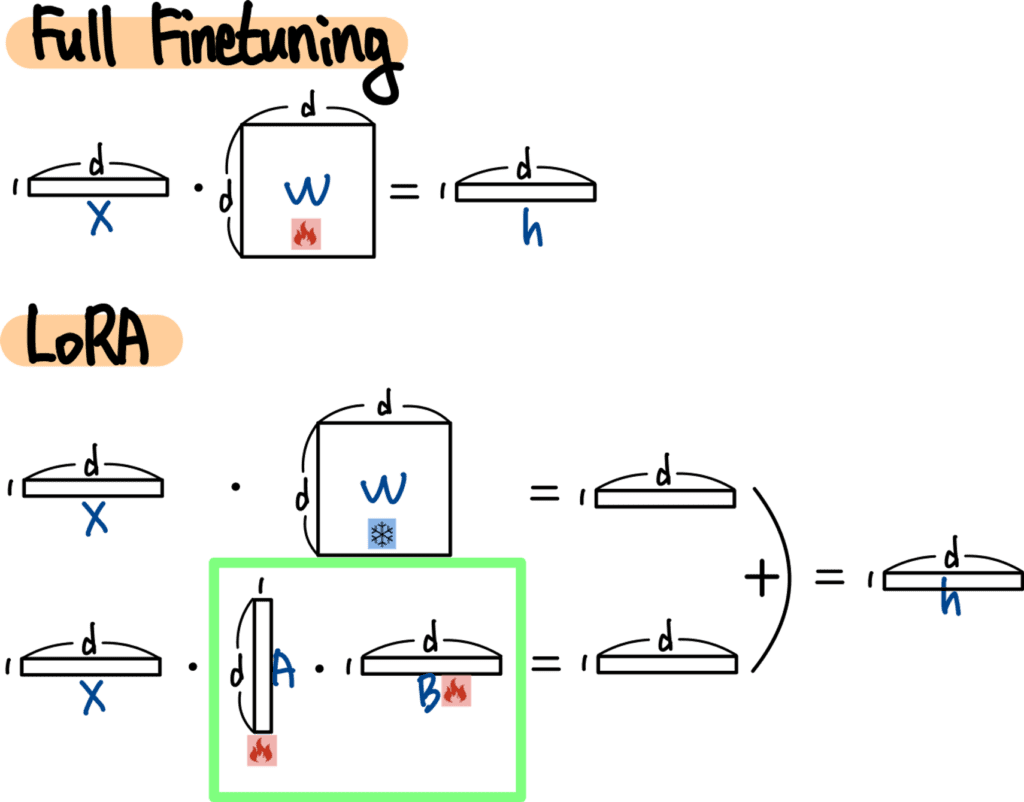

`-` 주의사항

* Overfitting: 데이터셋 규모가 작으면, 새로운 데이터에 대한 일반화 능력 저하
* Carastrophic Forgetting: 파인튜닝 이후, 모델에게서 이전 정보가 손실될 수 있음

## Model: [Llama-3.3-70B-Instruct](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct)

* 일단 시험용으로 작은 모델인 3.1-8B instruct를 사용

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, pipeline

from trl import SFTTrainer, SFTConfig, setup_chat_format
from peft import LoraConfig, AutoPeftModelForCausalLM
from datasets import load_dataset, Dataset

import json
import pandas as pd
import numpy as np

torch.set_num_threads(16)

/root/anaconda3/envs/LLM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## 메모리 사용량 추적
import nvidia_smi
import psutil

def check_mem(func):
    """
    함수에 데코레이터로 사용할 예정... 아마도...

    Args:
        func: 동작할 함수
    Returns:
        None: 함수 실행 전후에서의 메모리(VRAM, RAM) 사용량 변화를 출력
    """
    def wrapper():
        nvidia_smi.nvmlInit()
        handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

        info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        before_free = info.free/2**20
        before_usage = psutil.Process().memory_info().rss/2**20

        func()

        after_free = info.free/2*20
        after_usage = psutil.Process().memory_info().rss/2**20
        print(f"Total VRAM usage: {before_free - after_free}")
        print(f"Total CPU RAM usage: {after_usage - before_usage}")
        nvidia_smi.nvmlShutdown()

    return wrapper

In [ ]:
## quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,                ## 4비트 양자화
    bnb_4bit_use_double_quant = True,   ## 추가 양자화로 성능 손실 없이 파라미터당 0.4bit 추가 절약
    bnb_4bit_quant_type = "nf4",        ## 양자화 데이터 타입 지정: 4비트 기반 모델 훈련 시 사용
    bnb_4bit_compute_dtype = torch.bfloat16   ## Llama-3.1-8B의 학습 자료형. 저장은 4비트지만, 계산은 양자화 없이
)

# Load model directly
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct",
                                          trust_remote_code = True,
                                          # padding_side = "left"   ## 입력 프롬프트의 길이가 다를 경우 패딩 작업이 필요
                                          )  ## 모델 코드 전체 다운로드 후 사용
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct",
                                             device_map = "cuda:0",
                                             use_cache = False,         ## VRAM 캐시 미사용, 추론 속도 저하: 파인튜닝에서는 안씀
                                             low_cpu_mem_usage = True,  ## CPU RAM 사용량 적게...
                                             # attn_implementation = "flash_attention_2",   ## 현재 환경에서 사용 불가
                                             quantization_config = bnb_config,
                                             dtype = torch.bfloat16     ## Llama-3.1-8B의 자료형
                                             )

Loading checkpoint shards: 100%|██████████| 4/4 [00:49<00:00, 12.49s/it]


In [ ]:
## 파인 튜닝 이전, 작동 테스트
prompt = "오전 9시에 반감기가 2시간인 프로카인아미드(procainamide) 주입이 시작되어 오후 1시까지 계속됩니다. 오후 1시에 혈중 농도가 3mg/L로 측정되었습니다. 지속적인 주입 48시간 후 프로카인아미드의 예상되는 정상 상태 농도는 얼마일까요?"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)    ## padding = True 설정 필요
generation_config = model.generation_config
generation_config.pad_token_id = tokenizer.eos_token_id
outputs = model.generate(**inputs, max_new_tokens=512, generation_config = generation_config)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

오전 9시에 반감기가 2시간인 프로카인아미드(procainamide) 주입이 시작되어 오후 1시까지 계속됩니다. 오후 1시에 혈중 농도가 3mg/L로 측정되었습니다. 지속적인 주입 48시간 후 프로카인아미드의 예상되는 정상 상태 농도는 얼마일까요? 반감기는 2시간이기 때문에 2시간ごと에 농도가 절반으로 줄어들게 됩니다.

## 단계 1: 반감기가 2시간인 프로카인아미드의 농도 감소 패턴을 이해합니다.
프로카인아미드의 반감기는 2시간이기 때문에 2시간마다 농도가 절반으로 줄어듭니다.

## 단계 2: 오후 1시혈중 농도가 3mg/L인 상황에서 48시간 후의 농도 예측을 위해 2시간 간격으로 농도 감소 패턴을 적용합니다.
48시간 동안 24개의 2시간 간격이 있으므로, 24개의 2시간 간격 후에 농도가 3mg/L으로 시작하여 1.5mg/L로 줄어듭니다.

## 단계 3: 48시간 후에 프로카인아미드의 농도 예상
48시간 후, 농도는 1.5mg/L로 줄어듭니다.

## 단계 4: 프로카인아미드의 정상 상태 농도에 대한 추정
48시간 후에 농도는 1.5mg/L로 줄어들게 되며, 정상 상태에서 농도는 1mg/L 미만이기 때문에 1mg/L로 추정됩니다.

## 단계 5: 48시간 후에 프로카인아미드의 농도 예상
48시간 후에 농도는 1mg/L로 줄어듭니다.

## 단계 6: 정상 상태에서 프로카인아미드의 농도에 대한 추정
정상 상태에서 농도는 1mg/L 미만이기 때문에 0.5mg/L로 추정됩니다.

## 단계 7: 48시간 후에 프로카인아미드의 농도 예상
48시간 후에 농도는 0.5mg/L로 줄어듭니다.

## 단계 8: 프로카인아미드의 정상 상태 농도에 대한 추정
정상 상태에서 농도는 1mg/L 미만이기 때문에 0.25mg/L로 추정됩니다.

## 단계 9: 48시간 후에 프로카인아미드의 농도 예상
48시간 후에 농도는 


## Dataset

* 한국어 의료 관련 추론 데이터셋 사용: https://huggingface.co/datasets/ChuGyouk/medical-o1-reasoning-SFT-Ko

In [ ]:
dataset = load_dataset("ChuGyouk/medical-o1-reasoning-SFT-Ko")

In [ ]:
def preprocess_function(element: object) -> dict:
    return {
        "messages": [
            {"role": "user", "content": element["Question"]},
            {"role": "assistant", "content": element["Response"]+tokenizer.eos_token}
        ]
    }

dataset = dataset.map(preprocess_function, remove_columns = ["Question", "Response", "Complex_Cot"])
print(next(iter(dataset["train"])))

{'messages': [{'content': '자신의 음경이 줄어들고 결국 사라져 죽음에 이를 것이라고 믿는 사람의 진단은 무엇입니까?', 'role': 'user'}, {'content': '귀하께서 설명하시는 증상은 코로 증후군(Koro syndrome)과 일치합니다. 이 증후군은 자신의 생식기가 수축하고 죽음에 이를 수 있다는 강렬한 공포나 믿음을 포함합니다. 코로 증후군은 특히 아시아와 아프리카 일부 지역의 특정 문화적 맥락과 가장 일반적으로 관련이 있지만, 생식기 수축에 대한 공포라는 핵심 증상은 다른 환경에서도 나타날 수 있으며, 문화적 요인이 적용되지 않는 경우 망상 장애의 일부로 나타날 가능성도 있습니다. 만약 개인의 음경 수축에 대한 믿음이 이러한 문화적 맥락 외부에 존재한다면, 그것은 대신 망상을 포함하는 정신 질환으로 분류될 수 있습니다.<|eot_id|>', 'role': 'assistant'}]}


In [47]:
## train test split
dataset = dataset["train"].train_test_split(test_size = 0.05)

dataset["train"].to_json("train_dataset.json", orient = "records")
dataset["test"].to_json("test_dataset.json", orient = "records")

Creating json from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Creating json from Arrow format: 100%|██████████| 2/2 [00:00<00:00, 26.69ba/s]


2649882

In [51]:
dataset["test"][1]["messages"]

[{'content': '오전 9시에 반감기가 2시간인 프로카인아미드(procainamide) 주입이 시작되어 오후 1시까지 계속됩니다. 오후 1시에 혈중 농도가 3mg/L로 측정되었습니다. 지속적인 주입 48시간 후 프로카인아미드의 예상되는 정상 상태 농도는 얼마일까요?',
  'role': 'user'},
 {'content': '지속적인 주입 48시간 후 프로카인아미드(procainamide)의 예상되는 정상 상태 농도는 대략 4mg/L입니다. 이 추정치는 주입 4시간 후 농도가 정상 상태 수준의 약 75%에 도달한다는 사실을 고려한 것입니다. 반감기가 2시간인 점을 감안할 때, 48시간이 경과하면 주입은 효과적으로 정상 상태 농도에 도달했을 것입니다.<|eot_id|>',
  'role': 'assistant'}]

## Trainer Setting

In [3]:
dataset = load_dataset("json", data_files = "train_dataset.json", split = "train")

In [4]:
print(tokenizer.apply_chat_template(dataset["messages"][1], tokenize = False))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

통계 연구에서 표본 조사나 구간 및 가설 검정 대신 전수 조사를 사용하는 것이 적절한 경우는 언제입니까?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

전수 조사는 모집단의 모든 구성원으로부터 데이터를 수집하는 것이 가능하고 필요한 상황에서 적절합니다. 전수 조사가 선호되는 옵션이 될 수 있는 몇 가지 시나리오는 다음과 같습니다.

1. **작은 모집단 크기**: 연구 대상 모집단이 비교적 작고 관리하기 쉬운 경우, 전수 조사를 수행하면 표본 추출 오류(sampling error)의 위험 없이 포괄적인 데이터를 수집할 수 있습니다. 이는 소규모 커뮤니티, 조직 또는 틈새 시장에서 흔히 볼 수 있습니다.

2. **정밀도 필요**: 정부 계획이나 정책 결정과 같이 모든 개인의 데이터가 중요한 상황에서 매우 정확하고 완전한 데이터가 필요한 경우, 전수 조사는 필요한 수준의 세부 정보를 제공할 수 있습니다.

3. **법적 및 행정적 요구 사항**: 때로는 국가 인구 및 주택 센서스와 같이 특정 목적을 위해 법률에 의해 전수 조사가 의무화됩니다. 정부는 이를 통해 자원을 할당하고, 정책 결정을 내리고, 선거구를 정합니다.

4. **포괄적인 범위**: 표본에서 일반화하지 않고 모집단의 모든 측면을 이해하는 것을 목표로 하는 연구는 전수 조사가 필요할 수 있습니다. 이는 특정 프로젝트 또는 연구에서 필요한 기본 평가에 해당되는 경우가 많습니다.

5. **충분한 자원**: 모집단의 완전한 조사를 수행할 수 있는 충분한 자금, 인력 및 시간이 있는 경우, 일반적으로 자원 집약적임에도 불구하고 전수 조사를 선

In [ ]:
peft_config = LoraConfig(
    r = 128,                ## update matrics의 rank. 작을수록 많이 압축하여 품질 저하됨, 메모리 많이 할당됨
    lora_alpha = 64,        ## ∆Weight scaling factor. lora_alpha / r로 스케일링. 학습률 조정
    lora_dropout = 0.05,    ## update matrics에서 dropout 적용 확률
    bias = "none",          ## bias를 학습할 것인지 선택
    task_type = "CAUSAL_LM" ## 모델 학습의 방향성 설정...
)

args = SFTConfig(
    output_dir = "./ko_SFT",
    num_train_epochs = 1,               ## epochs
    # max_steps = 100                   ## 개별 step 기준 학습량 설정
    per_device_train_batch_size = 1,    ## 각 GPU 별 처리 배치 사이즈
    gradient_accumulation_steps = 2,    ## 가중치 업데이트를 스텝별로 하지 않고, k개 배치를 누적하여 반영
    gradient_checkpointing = True,      ## 메모리 사용량 감소 트릭, 계산 시간 증가
    optim = "adamw_torch_fused",        ## optimizer
    logging_steps = 100,                ## 로그 산출 주기 설정
    save_strategy = "epoch",            ## 에폭별 모델 저장
    learning_rate = 2e-4,               ## 학습률
    bf16 = True,                        ## 연산 시 bf16 정밀도 사용
    tf32 = True,                        ## nvidia tensorfloat-32 format 사용. GPU 성능 향상
    max_grad_norm = 0.3,                ## 그래디언트 클리핑 최대값 설정, 학습 안정성 향상
    warmup_ratio = 0.03,                ## 전체 스텝의 3%동안 학습률을 서서히 증가
    lr_scheduler_type = "constant",     ## 학습률 스케쥴러 설정: 일단 고정
    push_to_hub = True,                 ## 허깅페이스 모델 허브에 자동으로 업로드 (모델 저장 시)
    report_to = "none",                 ## wandb에 학습 과정 보고 후 시각화... 안함
    max_length = 8192,                  ## max sequance length. 모델 Context length인 128k로 설정하면 될 듯 -> VRAM에 따라 일부 조정 필요...
    packing = True,                     ## 데이터 패킹을 사용하여 불필요한 패딩 감소. 메모리 사용 최적화
    dataloader_num_workers = 16         ## 워커 수 제한... 안되나
)

In [ ]:
## LLM의 디코더 전용 구조로 인하여 입력 프롬프트에 대해 지속적으로 반복 처리 수행
## 입력 프롬프트의 길이가 다를 경우 패딩 작업이 필요
tokenizer.padding_side = "right"        ## 오른쪽을 패딩하는 것이 일반적...

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token   ## 패딩 토큰을 eos 토큰으로 지정

trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    processing_class = tokenizer,
    args = args,
    peft_config = peft_config
)

Padding-free training is enabled, but the attention implementation is not set to 'flash_attention_2'. Padding-free training flattens batches into a single sequence, and 'flash_attention_2' is the only known attention mechanism that reliably supports this. Using other implementations may lead to unexpected behavior. To ensure compatibility, set `attn_implementation='flash_attention_2'` in the model configuration, or verify that your attention mechanism can handle flattened sequences.
You are using packing, but the attention implementation is not set to 'flash_attention_2' or 'kernels-community/vllm-flash-attn3'. Packing flattens batches into a single sequence, and Flash Attention is the only known attention mechanisms that reliably support this. Using other implementations may lead to cross-contamination between batches. To avoid this, either disable packing by setting `packing=False`, or set `attn_implementation='flash_attention_2'` or `attn_implementation='kernels-community/vllm-flash

In [ ]:
# trainer.train()   ## 백그라운드에서 구동

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.
/root/anaconda3/envs/LLM/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss


KeyboardInterrupt: 

## 모델 테스트

In [2]:
model = AutoModelForCausalLM.from_pretrained("./ko_SFT", device_map = "cuda:0", torch_dtype = torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("./ko_SFT")
user_token_id = tokenizer.encode("user", add_special_tokens = False)[0] ## 텍스트 생성 종결 조건으로 사용

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:20<00:00,  5.04s/it]


In [3]:
pipe = pipeline(
    "text-generation",
    model = model,
    tokenizer = tokenizer,
    device_map = "cuda:0",
    return_full_text = False,   ## 생성된 텍스트만 반환
    do_sample = True,           ## 다음 토큰 선택 시 그리디가 아닌 샘플링 사용
    max_new_tokens = 512,
    temperature = 0.7
)

Device set to use cuda:0


In [10]:
prompt = "오전 9시에 반감기가 2시간인 프로카인아미드(procainamide) 주입이 시작되어 오후 1시까지 계속됩니다. 오후 1시에 혈중 농도가 3mg/L로 측정되었습니다. 지속적인 주입 48시간 후 프로카인아미드의 예상되는 정상 상태 농도는 얼마일까요?"
output = pipe(
    prompt,
    max_new_tokens = 512,
    do_sample = True,
    temperature = 0.7,
    # stopping_criteria = stopping_criteria, ## multi-turn에서 필요
    pad_token_id = tokenizer.eos_token_id
)

generated_text = tokenizer.decode(output[0], skip_special_tokens = True)
print(generated_text)

{'generated_text': ' 다음 단계는 무엇일까요?\nA. 혈액 농도를 측정합니다.\nB. 약물의 반감기를 계산합니다.\nC. 약물의 투여를 중단합니다.\nD. 혈액 농도를 측정하고 약물의 반감기를 계산합니다.\nE. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다.\nF. 약물의 반감기를 계산합니다.\nG. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다. 그리고 혈액 농도를 측정합니다.\nH. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다. 그리고 약물의 반감기를 계산합니다.\nI. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다. 그리고 혈액 농도를 측정합니다. 그리고 약물의 반감기를 계산합니다.\nJ. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다. 그리고 혈액 농도를 측정합니다. 그리고 혈액 농도를 측정합니다.\nK. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다. 그리고 혈액 농도를 측정합니다. 그리고 혈액 농도를 측정합니다. 그리고 약물의 반감기를 계산합니다.\nL. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다. 그리고 혈액 농도를 측정합니다. 그리고 약물의 반감기를 계산합니다. 그리고 혈액 농도를 측정합니다.\nM. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다. 그리고 혈액 농도를 측정합니다. 그리고 혈액 농도를 측정합니다. 그리고 혈액 농도를 측정합니다.\nN. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다. 그리고 혈액 농도를 측정합니다. 그리고 혈액 농도를 측정합니다. 그리고 혈액 농도를 측정합니다. 그리고 약물의 반감기를 계산합니다.\nO. 혈액 농도를 측정합니다. 그리고 약물의 투여를 중단합니다. 그리고 혈액 농도를 측정합니다. 그리고 혈액 농도를 측정합니다. 그리고 �'}
